In [6]:
library(dplyr)   
library(caret)
library(tidyverse)
library(recipes)
library(pROC)
library(caTools)
library(UBL)

options(repr.plot.width = 20, repr.plot.height =10, repr.plot.res = 100)


load(file = "C:/Users/abonini/Desktop/Analysis/Sources/LIVERTRANSPLANT/Modello/df.Rdata")

In [7]:
tmp <- subset(df, select = -c(deg_cat))           #hot encoding

#define one-hot encoding function
dummy <- dummyVars(" ~ .", data=tmp)

#perform one-hot encoding on data frame
final_df <- data.frame(predict(dummy, newdata=tmp))


final_df$deg_cat <- df$deg_cat


df <- final_df

## Data partition

In [8]:
#make this example reproducible
set.seed(1)

#use 70% of dataset as training set and 30% as test set
sample <- sample.split(df$deg_cat, SplitRatio = 0.7)
train  <- subset(df, sample == TRUE)
test   <- subset(df, sample == FALSE)



TestClasses <- test$deg_cat
TestData <- subset(test,select= -deg_cat)

In [9]:
dim(test)
dim(train)

[1] 321 184

[1] 747 184

In [4]:
train <- SmoteClassif(deg_cat ~ ., train, k = 27, dist = "HEOM")

#view distribution of response variable in new dataset
table(train$deg_cat)

TrainClasses <- train$deg_cat
TrainData <- subset(train,select= -deg_cat)


Accettabile  Complicato      Ottimo 
        249         249         249 

## Model

In [5]:
ctrl <- trainControl(method = "repeatedcv", 
                 number = 10, 
                 savePredictions = "final",classProbs=TRUE,verboseIter=TRUE, search= "random") 

#summaryFunction = multiClassSummary (to keep all metrics)

In [6]:

model_svmPoly <- train(x=TrainData, y=TrainClasses, 
               method = "svmPoly", scale= FALSE) 

In [7]:

model_svmRadial <- train(x=TrainData, y=TrainClasses, 
               method = "svmRadial", scale= FALSE) 

Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."


In [8]:

model_svmLinear <- train(x=TrainData, y=TrainClasses, 
               method = "svmLinear", scale= FALSE)

# Results

Support Vector Machines with Polynomial Kernel 

747 samples
183 predictors
  3 classes: 'Accettabile', 'Complicato', 'Ottimo' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 747, 747, 747, 747, 747, 747, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa     
  1       0.001  0.25  0.3477963  0.04490107
  1       0.001  0.50  0.4433203  0.17959221
  1       0.001  1.00  0.5517243  0.33200671
  1       0.010  0.25  0.6097754  0.41553120
  1       0.010  0.50  0.6198692  0.43037428
  1       0.010  1.00  0.6291822  0.44386387
  1       0.100  0.25  0.6440065  0.46579526
  1       0.100  0.50  0.6447259  0.46697960
  1       0.100  1.00  0.6498821  0.47470105
  2       0.001  0.25  0.4514401  0.19109521
  2       0.001  0.50  0.5570573  0.33982352
  2       0.001  1.00  0.5993768  0.40011804
  2       0.010  0.25  0.6292852  0.44425281
  2       0.010  0.50  0.6408987  0.46133735
  2       0.010  1.00  0.6468823  0.

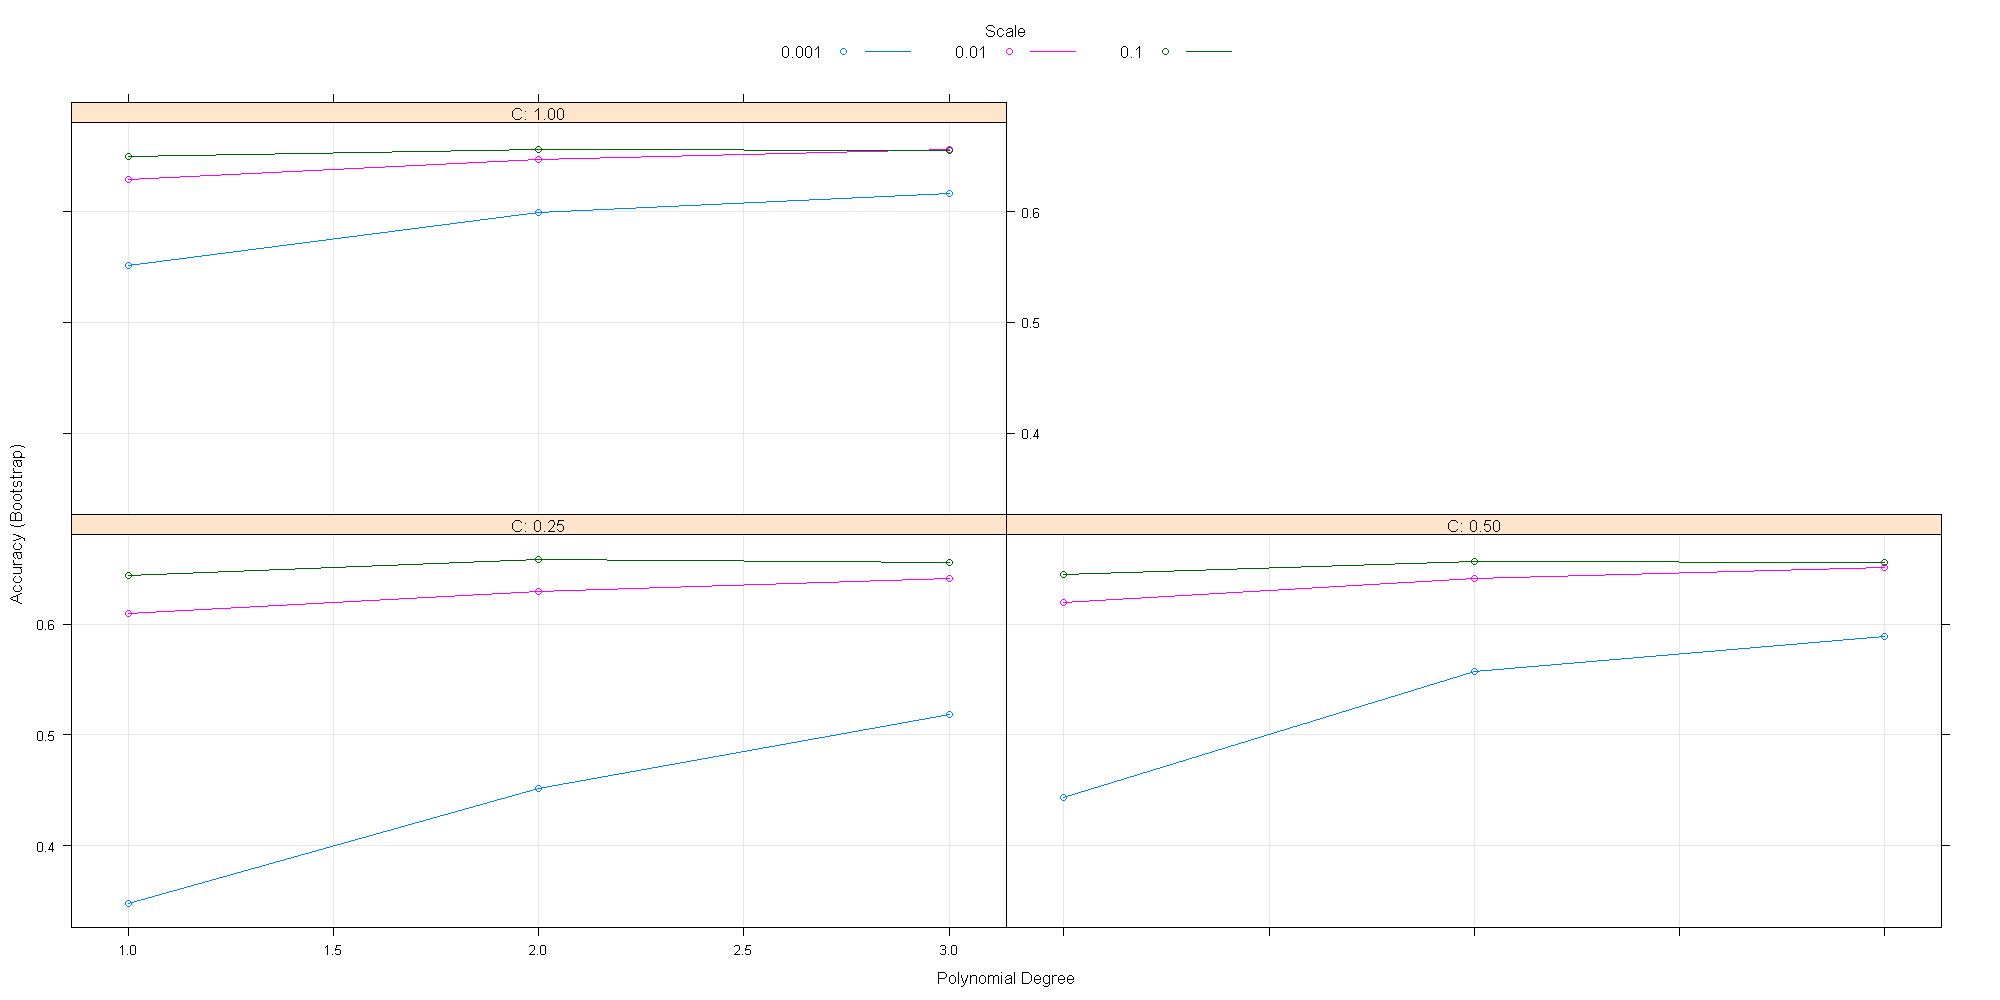

In [9]:
print(model_svmPoly)
plot(model_svmPoly)

Support Vector Machines with Radial Basis Function Kernel 

747 samples
183 predictors
  3 classes: 'Accettabile', 'Complicato', 'Ottimo' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 747, 747, 747, 747, 747, 747, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6276064  0.4410646
  0.50  0.6328206  0.4486842
  1.00  0.6400750  0.4595935

Tuning parameter 'sigma' was held constant at a value of 0.01710018
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.01710018 and C = 1.


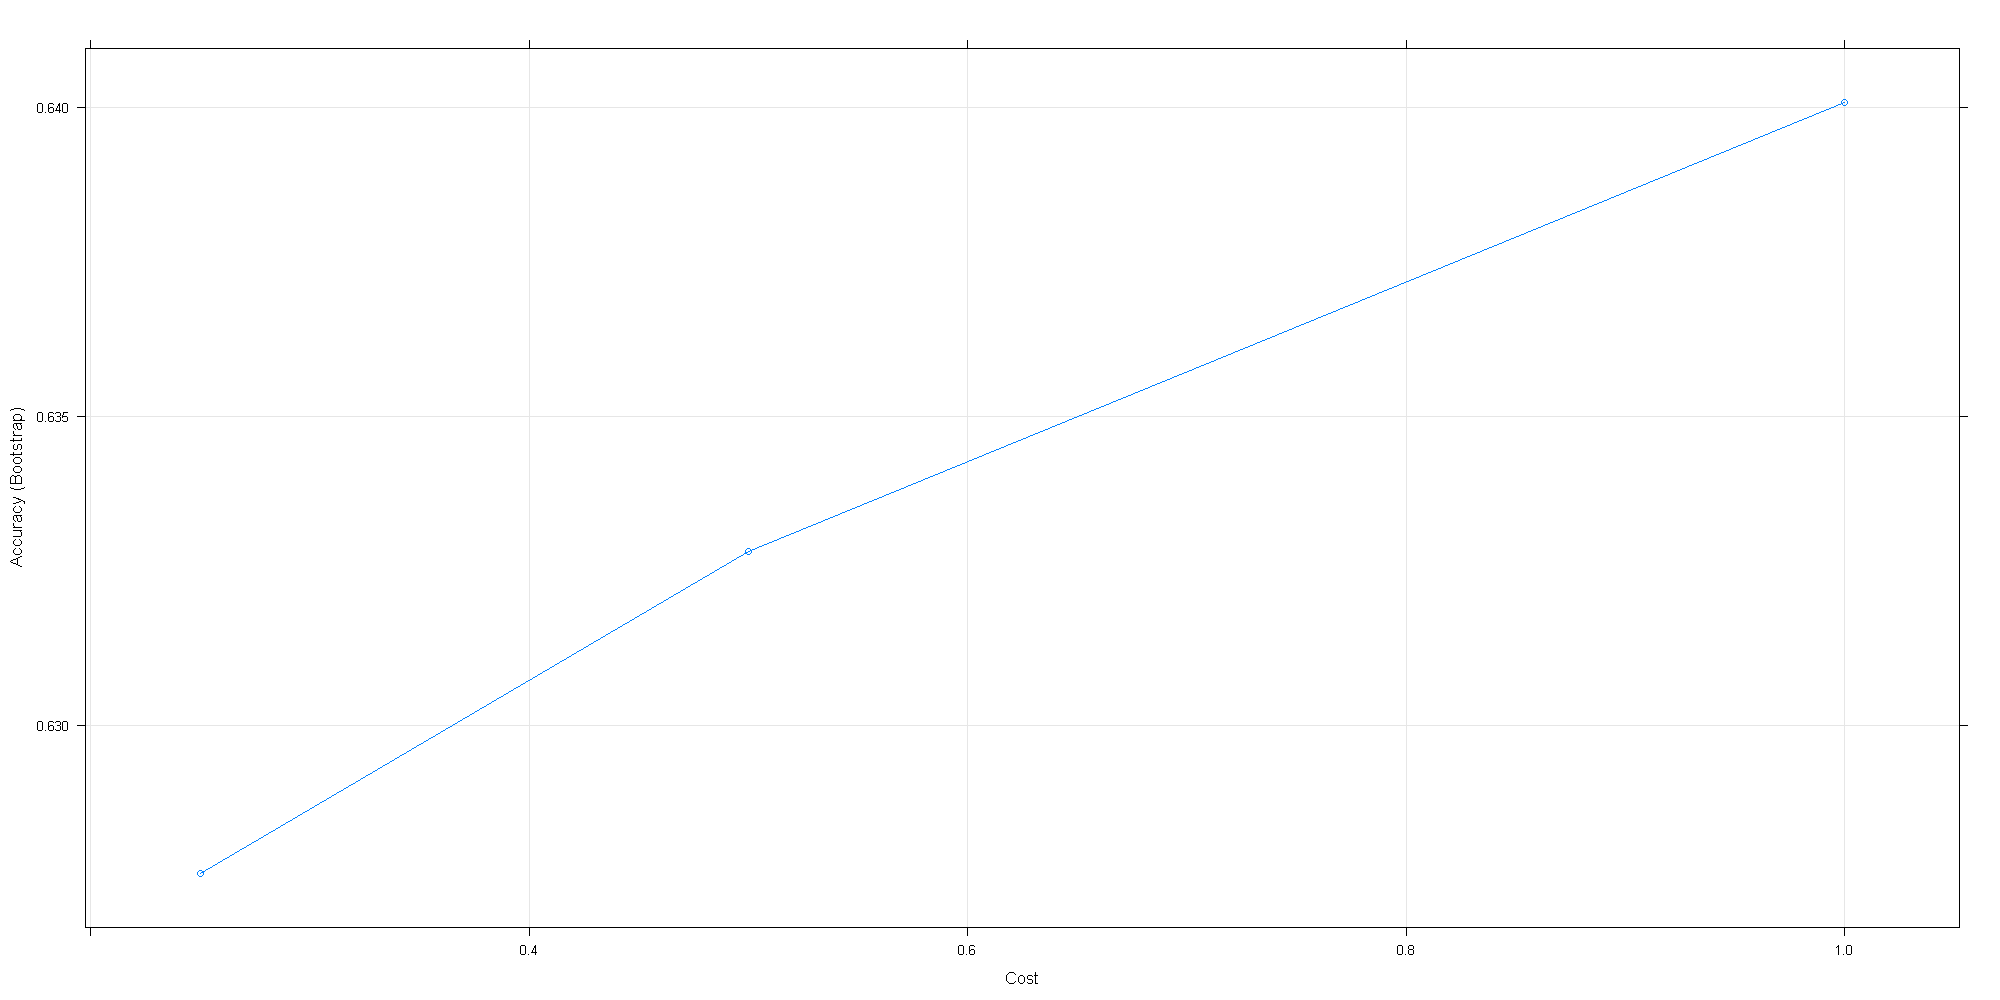

In [10]:
print(model_svmRadial)
plot(model_svmRadial)

In [12]:
print(model_svmLinear)
plot(model_svmLinear)

Support Vector Machines with Linear Kernel 

747 samples
183 predictors
  3 classes: 'Accettabile', 'Complicato', 'Ottimo' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 747, 747, 747, 747, 747, 747, ... 
Resampling results:

  Accuracy   Kappa    
  0.6417577  0.4621443

Tuning parameter 'C' was held constant at a value of 1


ERROR: Error in plot.train(model_svmLinear): There are no tuning parameters with more than 1 value.



Call:
summary.resamples(object = results)

Models: Poly, Radial, Linear 
Number of resamples: 25 

Accuracy 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Poly   0.6097561 0.6460481 0.6617647 0.6587730 0.6702899 0.7087719    0
Radial 0.5813149 0.6272401 0.6402878 0.6400750 0.6510791 0.6959707    0
Linear 0.6102362 0.6241379 0.6395349 0.6417577 0.6589147 0.6879699    0

Kappa 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Poly   0.4150744 0.4674496 0.4889724 0.4878613 0.5049083 0.5627380    0
Radial 0.3715585 0.4360859 0.4614282 0.4595935 0.4777689 0.5462574    0
Linear 0.4171476 0.4357574 0.4589365 0.4621443 0.4877487 0.5287312    0


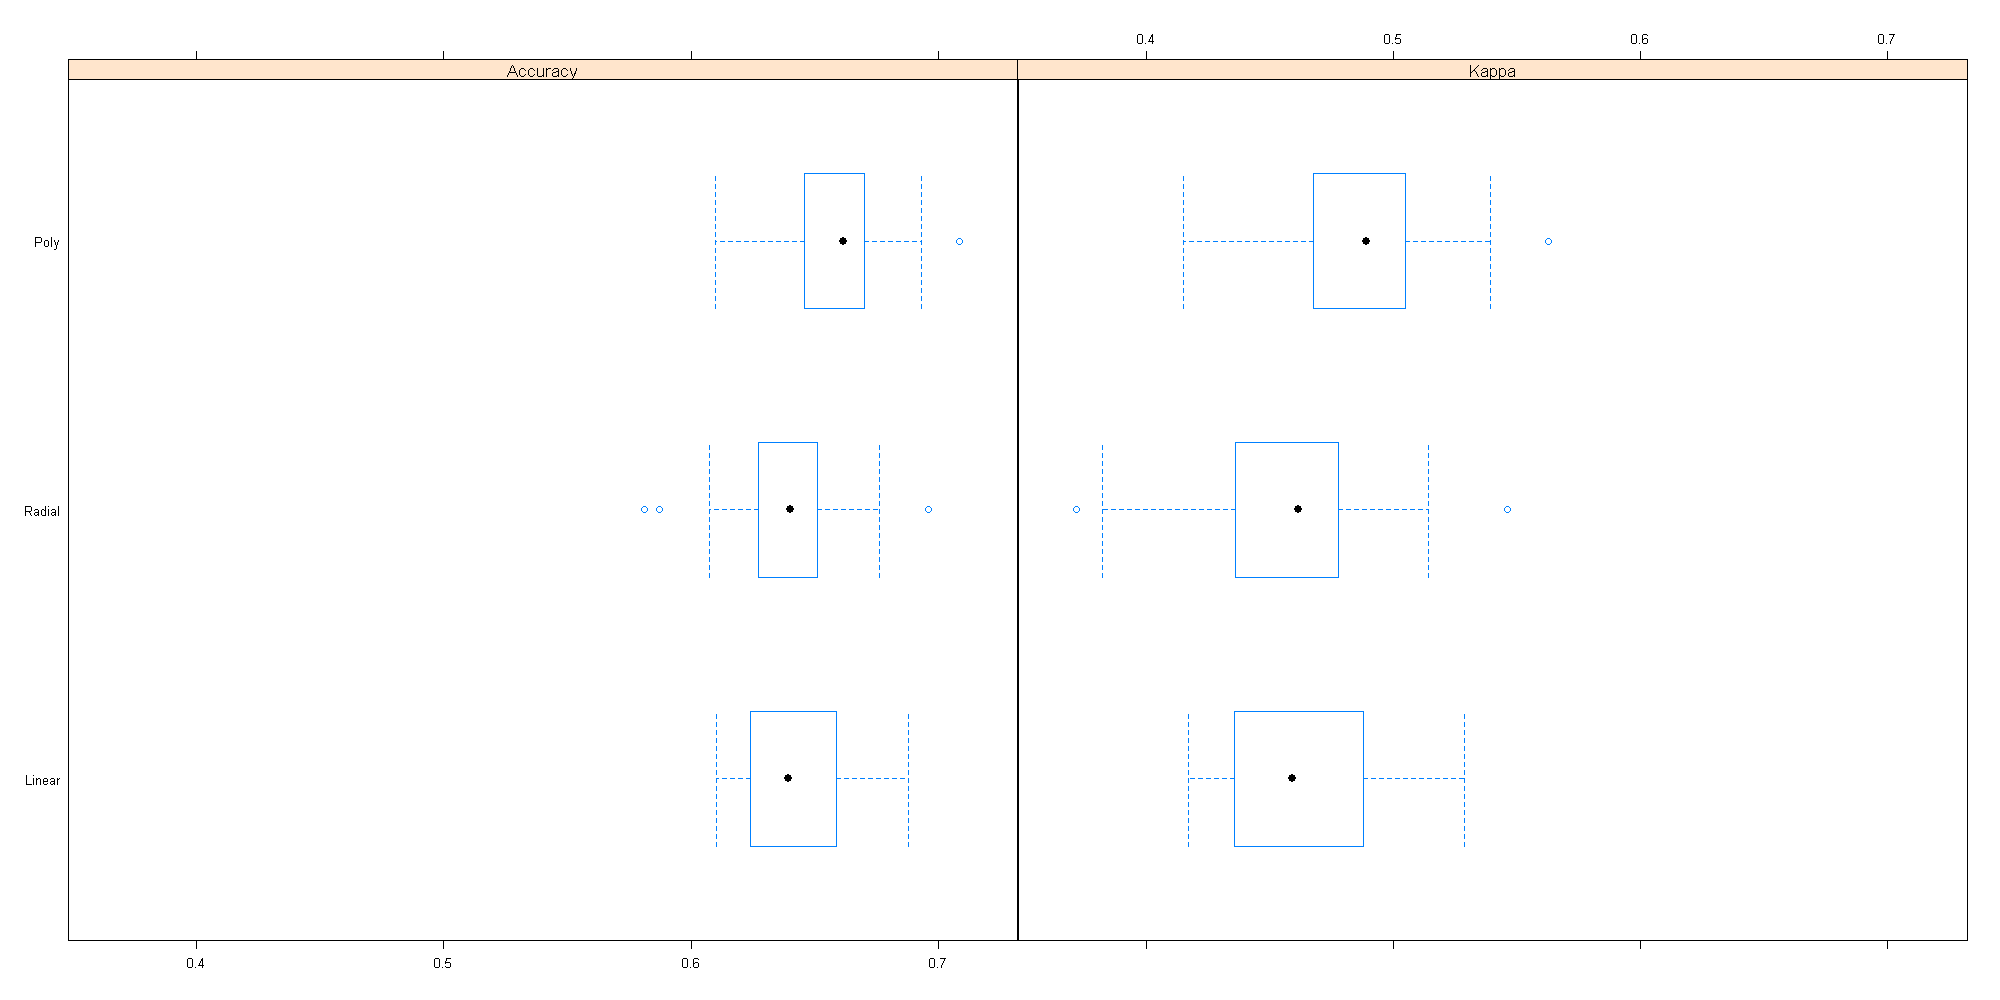

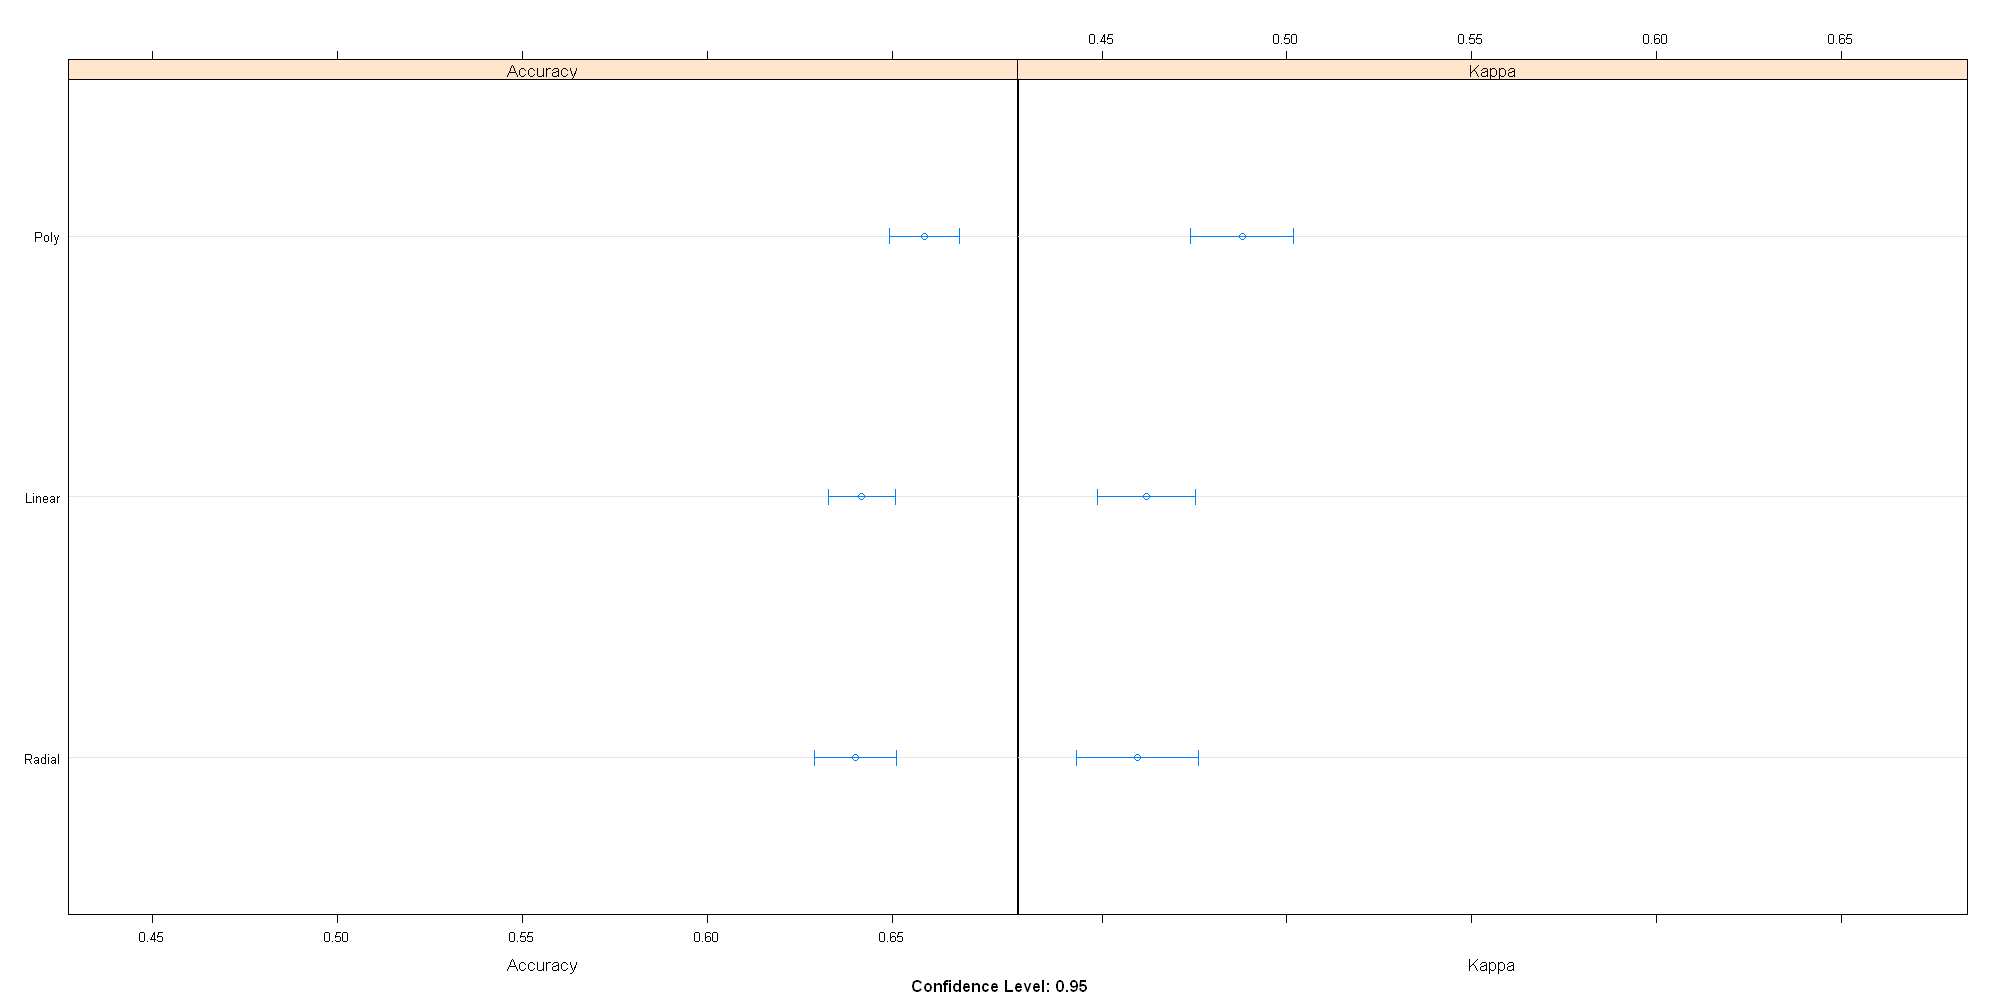

In [13]:
# collect resamples
results <- resamples(list(Poly=model_svmPoly,  Radial=model_svmRadial, Linear=model_svmLinear))
# summarize the distributions
summary(results)
# boxplots of results
bwplot(results)
# dot plots of results
dotplot(results)

# Prediction

In [16]:
pred_svmPoly <- predict(model_svmPoly,TestData)
pred_svmPoly.prob <- predict(model_svmPoly,TestData, type="prob")


result <- confusionMatrix(TestClasses,  pred_svmPoly) 
result
result$byClass

Warning message in method$prob(modelFit = modelFit, newdata = newdata, submodels = param):
"kernlab class probability calculations failed; returning NAs"


Confusion Matrix and Statistics

             Reference
Prediction    Accettabile Complicato Ottimo
  Accettabile          87         46     23
  Complicato           44         69      9
  Ottimo               20          5     18

Overall Statistics
                                          
               Accuracy : 0.5421          
                 95% CI : (0.4858, 0.5975)
    No Information Rate : 0.4704          
    P-Value [Acc > NIR] : 0.005974        
                                          
                  Kappa : 0.2474          
                                          
 Mcnemar's Test P-Value : 0.706331        

Statistics by Class:

                     Class: Accettabile Class: Complicato Class: Ottimo
Sensitivity                      0.5762            0.5750       0.36000
Specificity                      0.5941            0.7363       0.90775
Pos Pred Value                   0.5577            0.5656       0.41860
Neg Pred Value                   0.6121           

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: Accettabile,0.5761589,0.5941176,0.5576923,0.6121212,0.5576923,0.5761589,0.5667752,0.4704050,0.27102804,0.4859813,0.5851383
Class: Complicato,0.5750000,0.7363184,0.5655738,0.7437186,0.5655738,0.5750000,0.5702479,0.3738318,0.21495327,0.3800623,0.6556592
Class: Ottimo,0.3600000,0.9077491,0.4186047,0.8848921,0.4186047,0.3600000,0.3870968,0.1557632,0.05607477,0.1339564,0.6338745


In [17]:
pred_svmRadial <- predict(model_svmRadial,TestData)
pred_svmRadial.prob <- predict(model_svmRadial,TestData, type="prob")


result <- confusionMatrix(TestClasses,  pred_svmRadial) 
result
result$byClass

Warning message in method$prob(modelFit = modelFit, newdata = newdata, submodels = param):
"kernlab class probability calculations failed; returning NAs"


Confusion Matrix and Statistics

             Reference
Prediction    Accettabile Complicato Ottimo
  Accettabile          82         47     27
  Complicato           34         81      7
  Ottimo               14          4     25

Overall Statistics
                                          
               Accuracy : 0.5857          
                 95% CI : (0.5296, 0.6401)
    No Information Rate : 0.4112          
    P-Value [Acc > NIR] : 2.328e-10       
                                          
                  Kappa : 0.3342          
                                          
 Mcnemar's Test P-Value : 0.07106         

Statistics by Class:

                     Class: Accettabile Class: Complicato Class: Ottimo
Sensitivity                      0.6308            0.6136       0.42373
Specificity                      0.6126            0.7831       0.93130
Pos Pred Value                   0.5256            0.6639       0.58140
Neg Pred Value                   0.7091           

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: Accettabile,0.6307692,0.6125654,0.5256410,0.7090909,0.5256410,0.6307692,0.5734266,0.4049844,0.25545171,0.4859813,0.6216673
Class: Complicato,0.6136364,0.7830688,0.6639344,0.7437186,0.6639344,0.6136364,0.6377953,0.4112150,0.25233645,0.3800623,0.6983526
Class: Ottimo,0.4237288,0.9312977,0.5813953,0.8776978,0.5813953,0.4237288,0.4901961,0.1838006,0.07788162,0.1339564,0.6775133


In [18]:
pred_svmLinear <- predict(model_svmLinear,TestData)
pred_svmLinear.prob <- predict(model_svmLinear,TestData, type="prob")


result <- confusionMatrix(TestClasses,  pred_svmLinear) 
result
result$byClass

Warning message in method$prob(modelFit = modelFit, newdata = newdata, submodels = param):
"kernlab class probability calculations failed; returning NAs"


Confusion Matrix and Statistics

             Reference
Prediction    Accettabile Complicato Ottimo
  Accettabile          84         44     28
  Complicato           45         66     11
  Ottimo               12          5     26

Overall Statistics
                                          
               Accuracy : 0.5483          
                 95% CI : (0.4921, 0.6036)
    No Information Rate : 0.4393          
    P-Value [Acc > NIR] : 5.617e-05       
                                          
                  Kappa : 0.2752          
                                          
 Mcnemar's Test P-Value : 0.03415         

Statistics by Class:

                     Class: Accettabile Class: Complicato Class: Ottimo
Sensitivity                      0.5957            0.5739        0.4000
Specificity                      0.6000            0.7282        0.9336
Pos Pred Value                   0.5385            0.5410        0.6047
Neg Pred Value                   0.6545           

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: Accettabile,0.5957447,0.6000000,0.5384615,0.6545455,0.5384615,0.5957447,0.5656566,0.4392523,0.26168224,0.4859813,0.5978723
Class: Complicato,0.5739130,0.7281553,0.5409836,0.7537688,0.5409836,0.5739130,0.5569620,0.3582555,0.20560748,0.3800623,0.6510342
Class: Ottimo,0.4000000,0.9335938,0.6046512,0.8597122,0.6046512,0.4000000,0.4814815,0.2024922,0.08099688,0.1339564,0.6667969


In [19]:
roc_svmRadial <- multiclass.roc(TestClasses, as.numeric(pred_svmRadial))
roc_svmRadial

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases




Call:
multiclass.roc.default(response = TestClasses, predictor = as.numeric(pred_svmRadial))

Data: as.numeric(pred_svmRadial) with 3 levels of TestClasses: Accettabile, Complicato, Ottimo.
Multi-class area under the curve: 0.6404

percent,FALSE,FALSE
sensitivities,"1.0000000, 0.6744186, 0.5813953, 0.0000000","1.0000000, 0.6744186, 0.5813953, 0.0000000"
specificities,"0.0000000, 0.5256410, 0.8269231, 1.0000000","0.0000000, 0.2786885, 0.9426230, 1.0000000"
thresholds,"-Inf, 1.5, 2.5, Inf","-Inf, 1.5, 2.5, Inf"
direction,<,<
cases,"3, 3, 3, 3, 2, 3, 3, 1, 3, 2, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3","3, 3, 3, 3, 2, 3, 3, 1, 3, 2, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3"
controls,"3, 2, 1, 1, 2, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 3, 1, 2, 1, 3, 3, 3, 2, 1, 2, 2, 1, 3, 3, 1, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 3, 3, 2, 2, 3, 1, 3, 1, 1, 2, 2, 3, 1, 1, 2, 3, 1, 2, 2, 1, 1, 3, 3, 3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1","1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 3, 3, 1, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2"
fun.sesp,"function (thresholds, controls, cases, direction) , {, ncontrols <- length(controls), ncases <- length(cases), predictor <- c(controls, cases), response <- c(rep(0, length(controls)), rep(1, length(cases))), decr <- direction == ""<"", predictor.order <- order(predictor, decreasing = decr), predictor.sorted <- predictor[predictor.order], response.sorted <- response[predictor.order], tp <- cumsum(response.sorted == 1), fp <- cumsum(response.sorted == 0), se <- tp/ncases, sp <- (ncontrols - fp)/ncontrols, dups.pred <- rev(duplicated(rev(predictor.sorted))), dups.sesp <- duplicated(se) & duplicated(sp), dups <- dups.pred | dups.sesp, if (sum(!dups) != length(thresholds) - 1) {, sessionInfo <- sessionInfo(), save(thresholds, controls, cases, direction, sessionInfo, , file = ""pROC_bug.RData""), stop(sprintf(""pROC: fast algorithm computed an incorrect number of sensitivities and specificities. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>."", , utils::packageDescription(""pROC"")$BugReports)), }, if (direction == ""<"") {, se <- rev(c(0, se[!dups])), sp <- rev(c(1, sp[!dups])), }, else {, se <- c(0, se[!dups]), sp <- c(1, sp[!dups]), }, return(list(se = se, sp = sp)), }","function (thresholds, controls, cases, direction) , {, ncontrols <- length(controls), ncases <- length(cases), predictor <- c(controls, cases), response <- c(rep(0, length(controls)), rep(1, length(cases))), decr <- direction == ""<"", predictor.order <- order(predictor, decreasing = decr), predictor.sorted <- predictor[predictor.order], response.sorted <- response[predictor.order], tp <- cumsum(response.sorted == 1), fp <- cumsum(response.sorted == 0), se <- tp/ncases, sp <- (ncontrols - fp)/ncontrols, dups.pred <- rev(duplicated(rev(predictor.sorted))), dups.sesp <- duplicated(se) & duplicated(sp), dups <- dups.pred | dups.sesp, if (sum(!dups) != length(thresholds) - 1) {, sessionInfo <- sessionInfo(), save(thresholds, controls, cases, direction, sessionInfo, , file = ""pROC_bug.RData""), stop(sprintf(""pROC: fast algorithm computed an incorrect number of sensitivities and specificities. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>."", , utils::packageDescription(""pROC"")$BugReports)), }, if (direction == ""<"") {, se <- rev(c(0, se[!dups])), sp <- rev(c(1, sp[!dups])), }, else {, se <- c(0, se[!dups]), sp <- c(1, sp[!dups]), }, return(list(se = se, sp = sp)), }"
call,"roc.default(response = response, predictor = predictor, levels = X, , percent = percent, direction = ..1, auc = FALSE, ci = FALSE)","roc.default(respon

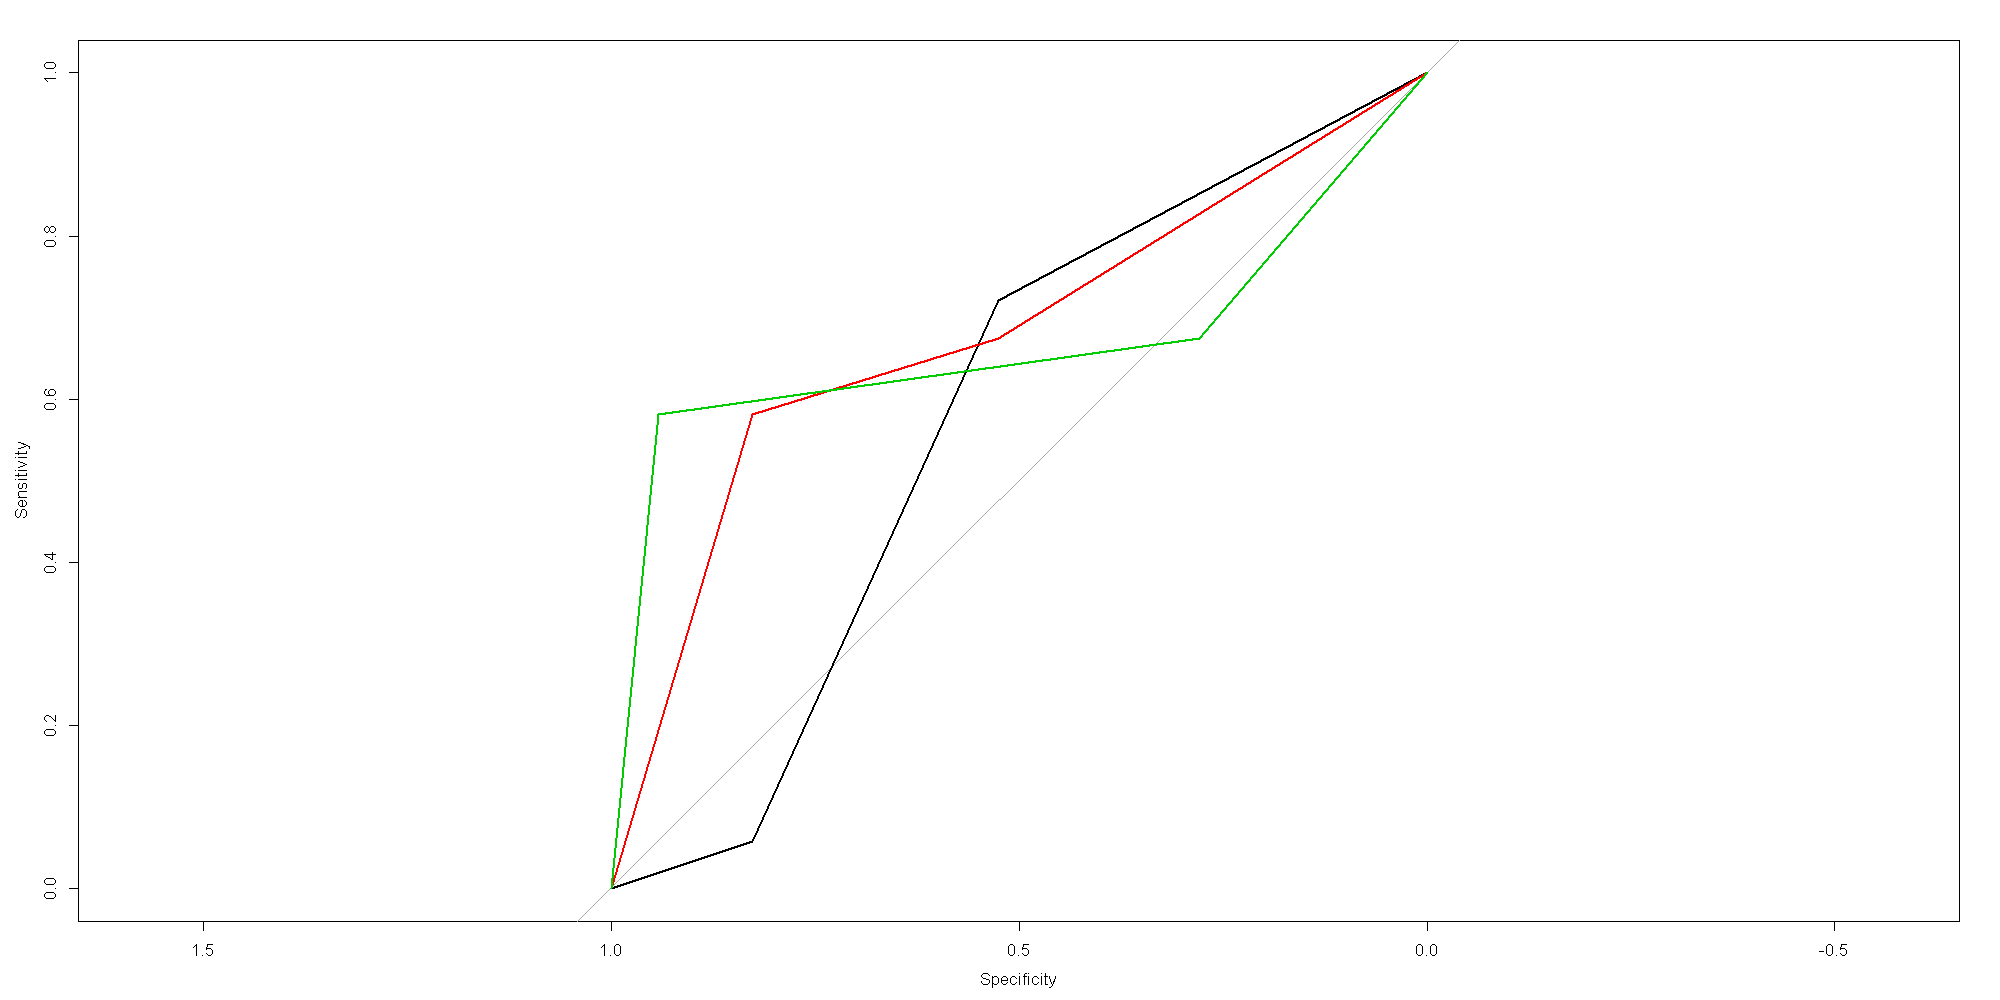

In [20]:
rs <- roc_svmRadial[['rocs']]
plot.roc(rs[[1]])
sapply(2:length(rs),function(i) lines.roc(rs[[i]],col=i))